# Clustering
- Unsupervised Learning for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction 
- is used for identifying similar instances and assigning them to clusters, or groups of similar instances

> The vast majority of the available data is unlabeled

## Top 5 clustering algorithm
- [K-Means](#kmeans)
- Mean-shift
- [DBSCAN (Density Based Spatial Clustering of Applications with Noise)](#dbscan)
- EM-GM (Expectation Maximization Clustering using Gaussian Mixture Models)
- Agglomerative Hierarchical Clustering



## How to chose
- on elliptical clusters, Gaussian mixture models perform better than K-Means



<a id='kmeans'></a>
### K-Means
> fast and scalable

computational complexity is generally linear, and therefore the fastest clustering algorithm


input features should be scaled, because it improves the usability of the data (more spherical) 

risk: unlucky centroid initialization (default is set to K-Means++ where this isn't a problem anymore)

if the data doesn't fit into memory:
- use `np.memmap`
    - creates a memory map to an array stored in a binary file on the disk
    - used for accessing small segments of large files on disk, without reading them into memory
- `partial_fit()`

#### Centroid initialization methods
- Manually, when you know where the centroids are (e.g. if you run one before) `init`
- Run multiple times with different random initializations and keep the best solution `n_init`
    - automatically set to 10
    - performance metric: <b>inertia</b> (mean squared distance between each instance and the closest centroid)
- <b>K-Means++</b> (default): initiate centroids that are distant from one another
    - method reduces the number of times KMeans needs to run to find the optimal solution.
    1. place centroid randomly in the dataset
    2. place new centroid, considering the distance to the fist centroid
    3. repeat steps until all centroids are are placed
- Using <b>Elkan</b> distance (default)
- <b>Mini-Batch</b>: makes it possible to cluster huge datasets that do not fit into memory
    - implementation over `MiniBatchKMeans`
    - is faster and reduces computational cost, but its inertia is slightly worse (especially when number of clusters increases)
    

#### Finding the optimal number of clusters
- Elbow (rather coarse)
- `silhouette_score` (computationally expensive)
    - can vary between -1 and 1 
- `silhouette diagram`
    - hight: number of instances the cluster contains
    - width: sorted silhouette coefficients of the instances in the cluster (wider is better)
    - should include a dashed line which indicates the mean silhouette score 
    - If all of the clusters are above the dashed line than we should take this k 
    
### Limits of K-Means
- needs to run multiple times
- specify number of clusters beforehand
- doesn't like clusters that vary in size, different densities and nonspherical shapes

In [47]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# generate some blobs
# code from Hands On Machine Learning Book
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

# function to plot blobs
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

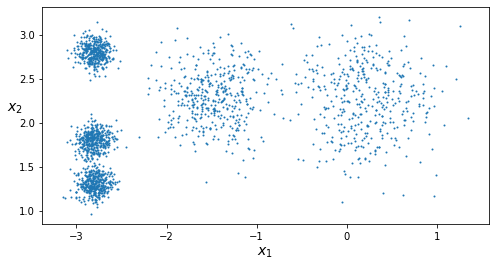

In [3]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### K-Means

In [4]:
# initiate KMeans with number of expected clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# use KMeans to get the clusters for the data 
ypred = kmeans.fit_predict(X)

In [5]:
# prediction for each datapoint
ypred

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

In [6]:
# the location of the centroids
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

plot centroids

In [7]:
def plot_centroids(cluster, centroids):
    '''
    INPUT
        cluster: array with the data points 
        centroids: array with the centroids
    
    OUTPUT
        visualization with the data and the centroids    
    '''
    # Data
    plt.scatter(cluster[:, 0], cluster[:, 1], s=0.5)
    
    # centroids from KMeans
    plt.scatter(centroids[:, 0], centroids[:, 1])
    
    plt.show()

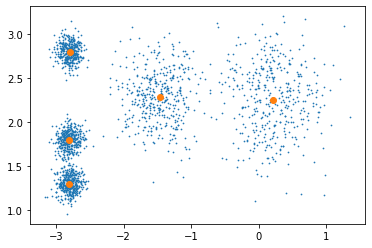

In [8]:
plot_centroids(X, kmeans.cluster_centers_)

> In this visualization you can clearly see that the centroids are perfectly in the middle of each cluster.

It is possible to plot the decision boundaries of each cluster

In [9]:
# check performace metric inertia
kmeans.inertia_

211.5985372581684

In [10]:
# is negative since a lower inertia score is better than a higher one
kmeans.score(X)

-211.59853725816856

#### Finding the optimal number of clusters
- Elbow
- silhouette score
- silhouette diagram

In [11]:
# lets chek with different values for k
kmeans3 = KMeans(n_clusters=3, random_state=42)
kmeans8 = KMeans(n_clusters=8, random_state=42)

ypred3 = kmeans3.fit(X)
ypred4 = kmeans8.fit(X)

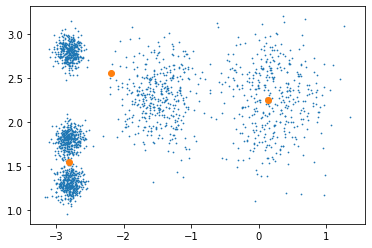

In [12]:
plot_centroids(X, kmeans3.cluster_centers_)

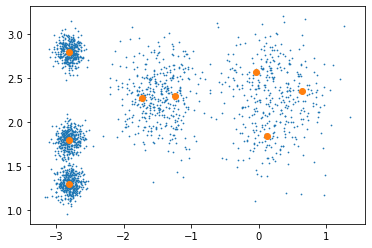

In [13]:
plot_centroids(X, kmeans8.cluster_centers_)

In [14]:
kmeans3.inertia_, kmeans8.inertia_

(653.2167190021553, 119.11983416102879)

> it is obvious from a visual perspective that both k values are wrong, but when we just look at the performance metric inertia it seems that the kmeans with 8 clusters performed better than the one with 5 clusters which had a higher inertia of 211. Inertia keeps getting lower as we increase k.

##### Elbow
- pick a point where the inertia decrease flattens

In [15]:
inertia = []
for k in range(1,9,1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

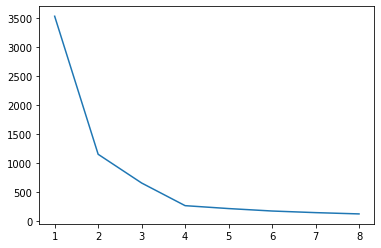

In [16]:
plt.plot(range(1,9,1), inertia)

> picking the k based on this diagram would result into = 4. But as we know 4 is not the right number of clusters

##### Silhouette score
- choose the number of clusters which has a score close to +1

In [17]:
# List Comprehension from hands one machine learning
# creats a list with all the models from 1 to 8 as the k 
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1,9,1)]

In [18]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]

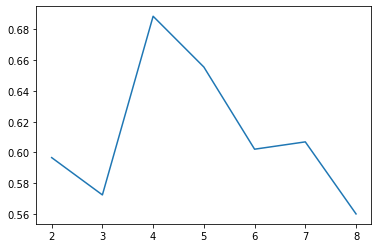

In [19]:
plt.plot(range(2,9,1), silhouette_scores)

> although it also supports that 4 is the best value to choose for k it also shows that k=5 wouldn't a bad pick either

##### Silhouette diagram

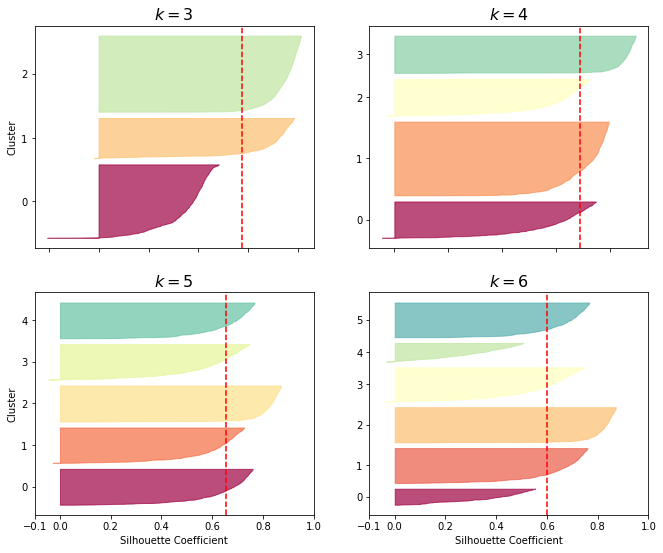

In [20]:
# code from hands one machie learning - added comments

# creats the overall size of the chart
plt.figure(figsize=(11, 9))

# for loop to go through each k
for k in (3, 4, 5, 6):
    # set the gird and assign a place for the plot
    plt.subplot(2, 2, k - 2)
    # get the labels for the datapoint from the list we crated before, -1 because the list starts at 0
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    
    
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        # set colormap to spectral
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

> this visualization clearly shows that k = 5 will result in the best results since all of the knife shapes are beyond the silhouette score for the number of clusters

#### Limits of K-Means
- non-spherical shapes
- different densities

In [21]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

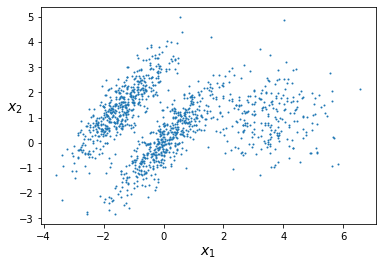

In [22]:
plot_clusters(X)

In [23]:
kmeans_limit = KMeans(n_clusters=3, random_state=42)
kmeans_limit.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

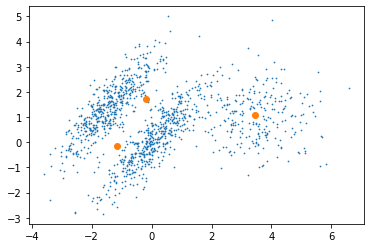

In [24]:
plot_centroids(X, kmeans_limit.cluster_centers_)

#### lets try to improve the clustering by scaling the features

In [25]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc

array([[ 0.32562502,  0.41028686],
       [ 0.05896349,  0.39213124],
       [-1.04024109, -0.67548985],
       ...,
       [ 1.42681516,  0.22251127],
       [ 2.24599313,  0.76711834],
       [ 1.72015581, -0.47231695]])

In [26]:
kmeans_sc = KMeans(n_clusters=3, random_state=42)
kmeans_sc.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

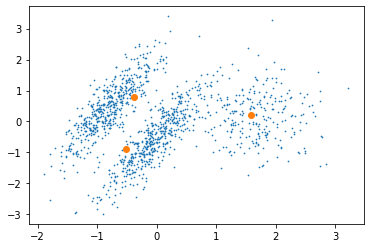

In [27]:
plot_centroids(X_sc, kmeans_sc.cluster_centers_)

In [28]:
kmeans_limit.inertia_, kmeans_sc.inertia_

(2179.4842787447324, 905.2082533198027)

> by scaling the features we have decreased the inertia but as you can see in the chart the centroids are still not perfect showing that non-spherical data shouldn't be clustered with K-Means

<a id='dbscan'></a>
### DBSCAN
- defines clusters as a continuous region of high density
- works well if all the clusters are dense enough and if they are well separated by low-density regions
- can identify any number of clusters of any shape
- robust to outliers
- computational complexity is close to linear but with high memory usage, when eps is high 
- it cannot predict which cluster a new instance belongs to.
    - have to use a classifier (KNN) with the data from the DBSCAN clustering  

#### Process
1. calculates how many instances are located within a small distance, for each instance
2. if an instances is located close to other instances than it is considered a core instance
3. core instances that are close together from a single cluster
4. instances that are not considered a core instance and don't have one around are considered an <b>anomaly</b>
    - those are returned as a -1 in the `labels_` instance





In [29]:
X, y = make_moons(n_samples=1000, noise= 0.05, random_state=42)

In [30]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [31]:
# label of each instance
# -1 is instances that are considered anomalies
dbscan.labels_

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4,  0,  5,  1,  0,  5,  5,  3,  2,  2,  2,  4,  5,  0,  6,
        1, -1,  0,  0,  2,  3, -1,  3,  4, -1,  4,  4,  2,  0,  6,  2,  0,
        2,  4,  0,  3,  3,  0,  3,  5,  2, -1,  3,  0,  5,  0,  0,  0,  2,
        3,  0,  3,  6,  0,  2,  4,  4,  0,  3,  0,  4,  0,  3, -1,  3,  4,
        0, -1,  2,  2,  4,  1,  6,  0,  5,  2,  6,  2,  3,  3, -1,  2, -1,
        2,  4,  0,  0,  0,  2,  5,  2,  0,  2, -1,  2,  3,  1,  5,  2,  0,
        4,  2,  1,  2,  4,  4,  0,  0,  6,  2,  2,  0,  2, -1,  2,  0,  3,
        3,  5, -1,  3,  3,  5,  2,  4,  2,  2,  2,  4,  2,  4,  0, -1,  2,
        1,  2,  6,  4,  2,  3,  2, -1,  2,  0,  0,  2,  0,  4,  0,  4,  4,
        1,  6,  3,  2,  6,  1,  4,  4,  2,  0,  6,  0,  1,  0,  2,  5,  1,
        1,  2,  2,  2,  2,  0,  5,  5,  1,  4,  5,  0,  3,  3,  0,  0,  0,
        2,  0,  5,  2, -1,  2,  3,  5,  2,  2,  0,  4,  0,  4,  2,  2,  4,
        2,  2,  3,  2,  3

In [32]:
# lets check how many instances are in each cluster
# code from https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python
unique, counts =  np.unique(dbscan.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 77, 0: 186, 1: 77, 2: 271, 3: 125, 4: 104, 5: 96, 6: 64}

> DBSCAN found 7 clusters, and 77 instances that were identified as anomalies

In [33]:
# location of the core instances
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [34]:
len(dbscan.labels_), len(dbscan.components_), len(X)

(1000, 808, 1000)

In [44]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

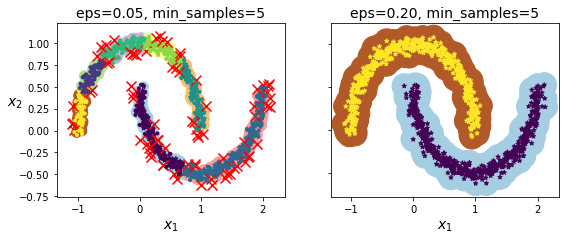

In [46]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [50]:
# will use the scond dbscan
dbscan = dbscan2

#### Predict new instances with KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [52]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [53]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

## Resources
- Hands-On Machine Learning with Scikit-Learn and TensorFlow
- https://www.kdnuggets.com/2018/06/5-clustering-algorithms-data-scientists-need-know.html
- https://www.kdnuggets.com/2020/02/understanding-density-based-clustering.html
- https://towardsdatascience.com/machine-learning-for-stock-clustering-using-k-means-algorithm-126bc1ace4e1
- https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray-in-python